# Homework 4
In this homework, we will delve deeper into panorama stitching. We'll also explore epipolar geometry and stereo matching.

## Submission Instructions
1. Make sure that the first line in any code cell with a function is the `def` line. <br>
The HW conversion script will fail to detect the function unless the function definition is on the first line of the code cell. <br>
Also double-check that each function is alone in its cell (there should be no function calls or imports anywhere in that cell).

2. Run the [conversion script](https://colab.research.google.com/drive/1DABLKz0Q9udhyZh1V6Ynv82PAsIws7-i?usp=sharing) to get your .py file. As a sanity check, the autograder expects the following functions in your .py file:
    * **`harris_corners`**
    * **`simple_descriptor`**
    * **`match_descriptors`**
    * **`fit_affine_matrix`**
    * **`ransac`**
    * **`linear_blend`**
    * **`stitch_multiple_images`**

  **The code you write in Part 2 will not be autograded, we'll grade it as part of the PDF.**

3. Make sure the Python file you upload to Gradescope is named **`hw4.py`**. This is required for the autograder to run correctly.

4. We added a section to the conversion script that generates an **HTML file that you can Ctrl+P and save as a PDF**. <br> This will ensure images don't get cut off in your submission.

_**Notes on Running This Notebook:**_

Make sure to run each part from its begining to ensure that you compute all of the dependencies of your current question and don't crossover variables with the same name from other questions. So long as you run each part from its beginning, you can run the parts in any order. When assembling your PDF, we recommend running all cells in order from the top of the notebook to prevent any of these discontinuity errors.

## Setup

In [9]:
import os

if not os.path.exists("CS131_release"):
    # Clone the repository if it doesn't already exist
    !git clone https://github.com/StanfordVL/CS131_release.git

%cd CS131_release/winter_2025/hw4_release/

Cloning into 'CS131_release'...
remote: Enumerating objects: 2568, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (146/146), done.
^Cceiving objects:  63% (1618/2568), 47.41 MiB | 13.27 MiB/s
[Errno 2] No such file or directory: 'CS131_release/winter_2025/hw4_release/'
/Users/jevonmao/Library/Mobile Documents/com~apple~CloudDocs/Stanford/CS 131/CS131_release/winter_2025/hw4_release


In [1]:
# Install the necessary dependencies
# (restart your runtime session if prompted to, and then re-run this cell)
!pip install -r requirements.txt

In [2]:
from __future__ import print_function

import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
from scipy.spatial.distance import cdist
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import cv2 as cv

from utils import pad, unpad, get_output_space, warp_image, plot_matches, describe_keypoints

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Part 1: Panorama Stitching

Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

**We will detect and match keypoints from multiple images to build a single panoramic image. This will involve several tasks:**
1. Compare two sets of descriptors coming from two different images and find matching keypoints *(we did this in Homework 2)*.
2. Given matching keypoints, use least-squares to find the affine transformation matrix that maps points in one image to another.
3. Use RANSAC to give a more robust estimate of the affine transformation matrix. <br>
Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.
4. Blend panorama images together to remove blurry regions of overlapping images.
5. Stich multiple panorama images together.


## 1. Describing and Matching Keypoints (0 points)
In Homework 2, recall that we used Harris corner detection to detect keypoints in two images. Given these two sets of keypoints, we then determined which pairs of keypoints come from the same 3D points projected onto the two images. We did so by first converting the region around each keypoint into a descriptor. Then, we found good matches in the two sets of descriptors based on Euclidean distance.

Add your code from Homework 2 for the three functions below. You can also feel free to paste in the reference solutions posted on Ed!


In [10]:
def harris_corners(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.ndimage.filters.convolve,
        which is already imported above. If you use convolve(), remember to
        specify zero-padding to match our equations, for example:

            out_image = convolve(in_image, kernel, mode='constant', cval=0)

        You can also use for nested loops compute M and the subsequent Harris
        corner response for each output pixel, intead of using convolve().
        Your implementation of conv_fast or conv_nested in HW1 may be a
        useful reference!

    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response = np.zeros((H, W))

    # 1. Compute x and y derivatives (I_x, I_y) of an image
    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)

    ### YOUR CODE HERE
    Ixx = dx ** 2
    Ixy = dx * dy
    Iyy = dy ** 2

    Sxx = convolve(Ixx, window, mode='constant', cval=0)
    Sxy = convolve(Ixy, window, mode='constant', cval=0)
    Syy = convolve(Iyy, window, mode='constant', cval=0)

    detM = (Sxx * Syy) - (Sxy ** 2)
    traceM = Sxx + Syy
    response = detM - k * (traceM ** 2)
    ### END YOUR CODE

    return response

def simple_descriptor(patch):
    """
    Describe the patch by normalizing the image values into a standard
    normal distribution (having mean of 0 and standard deviation of 1)
    and then flattening into a 1D array.

    The normalization will make the descriptor more robust to change
    in lighting condition.

    Hint:
        In this case of normalization, if a denominator is zero, divide by 1 instead.

    Args:
        patch: grayscale image patch of shape (H, W)

    Returns:
        feature: 1D array of shape (H * W)
    """

    feature = []

    ### YOUR CODE HERE
    patch_mean = np.mean(patch)
    patch_std = np.std(patch)
    if patch_std == 0:
        patch_std = 1
    normalized_patch = (patch - patch_mean) / patch_std
    feature = normalized_patch.flatten()
    ### END YOUR CODE

    return feature

def match_descriptors(desc1, desc2, threshold=0.5):
    """
    Match the feature descriptors by finding distances between them. A match is formed
    when the distance to the closest vector is much smaller than the distance to the
    second-closest, that is, the ratio of the distances should be STRICTLY SMALLER
    than the threshold (NOT equal to). Return the matches as pairs of vector indices.

    Hint:
        The Numpy functions np.sort, np.argmin, np.asarray might be useful

        The Scipy function cdist calculates Euclidean distance between all
        pairs of inputs
    Args:
        desc1: an array of shape (M, P) holding descriptors of size P about M keypoints
        desc2: an array of shape (N, P) holding descriptors of size P about N keypoints

    Returns:
        matches: an array of shape (Q, 2) where each row holds the indices of one pair
        of matching descriptors
    """

    matches = []

    M = desc1.shape[0]
    dists = cdist(desc1, desc2)

    ### YOUR CODE HERE
    if dists.shape[1] < 2:
        matches = np.empty((0, 2), dtype=int)
    else:
        sorted_indices = np.argsort(dists, axis=1)
        best_matches = sorted_indices[:, 0]
        second_best_matches = sorted_indices[:, 1]
        best_dists = dists[np.arange(M), best_matches]
        second_best_dists = dists[np.arange(M), second_best_matches]
        valid_mask = (second_best_dists > 0) & ((best_dists / second_best_dists) < threshold)
        matches = np.column_stack((np.where(valid_mask)[0], best_matches[valid_mask]))
    ### END YOUR CODE

    return matches

Run the following cell to detect and match the keypoints in two images.

In [11]:
img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

np.random.seed(131)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=5)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=5)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

## 2. Transformation Estimation (20 points)

Now, we will use these matched keypoints to find a **transformation matrix** that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, **we can estimate the transformation matrix with the least squares method.** Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** below.

*Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) for `np.linalg.lstsq`*

In [12]:
def fit_affine_matrix(p1, p2, to_pad=True):
    """
    Fit affine matrix such that p2 * H = p1. First, pad the descriptor vectors
    with a 1 using pad() to convert to homogeneous coordinates, then return
    the least squares fit affine matrix in homogeneous coordinates.

    Hint:
        You can use np.linalg.lstsq function to solve the problem.

        Explicitly specify np.linalg.lstsq's new default parameter rcond=None
        to suppress deprecation warnings, and match the autograder.

    Args:
        p1: an array of shape (M, P) holding descriptors of size P about M keypoints
        p2: an array of shape (M, P) holding descriptors of size P about M keypoints

    Return:
        H: a matrix of shape (P+1, P+1) that transforms p2 to p1 in homogeneous
        coordinates
    """

    assert (p1.shape[0] == p2.shape[0]),\
        'Different number of points in p1 and p2'

    if to_pad:
        p1 = pad(p1)
        p2 = pad(p2)

    ### YOUR CODE HERE
    H, _, _, _ = np.linalg.lstsq(p2, p1, rcond=None)
    ### END YOUR CODE

    # Sometimes numerical issues cause least-squares to produce the last
    # column which is not exactly [0, 0, 1]
    H[:,2] = np.array([0, 0, 1])
    return H

In [6]:
# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your **`fit_affine_matrix`** function is running correctly, run the following code to apply it to images.

Images will be warped and image 2 will be mapped to image 1.

Output shape: [493 631]
Offset: [-37.17230306   0.        ]


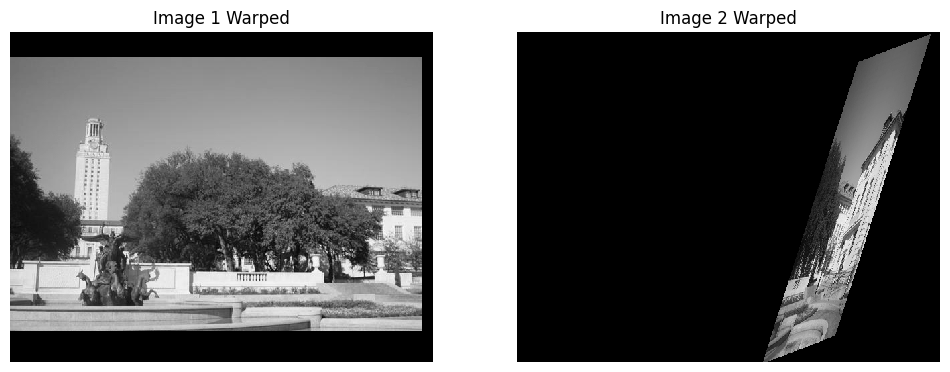

In [13]:
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 Warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 Warped')
plt.axis('off')

plt.show()

Next, the two warped images are merged to get a panorama.

Your panorama may not look good at this point, but we will later use other techniques to get a better result!

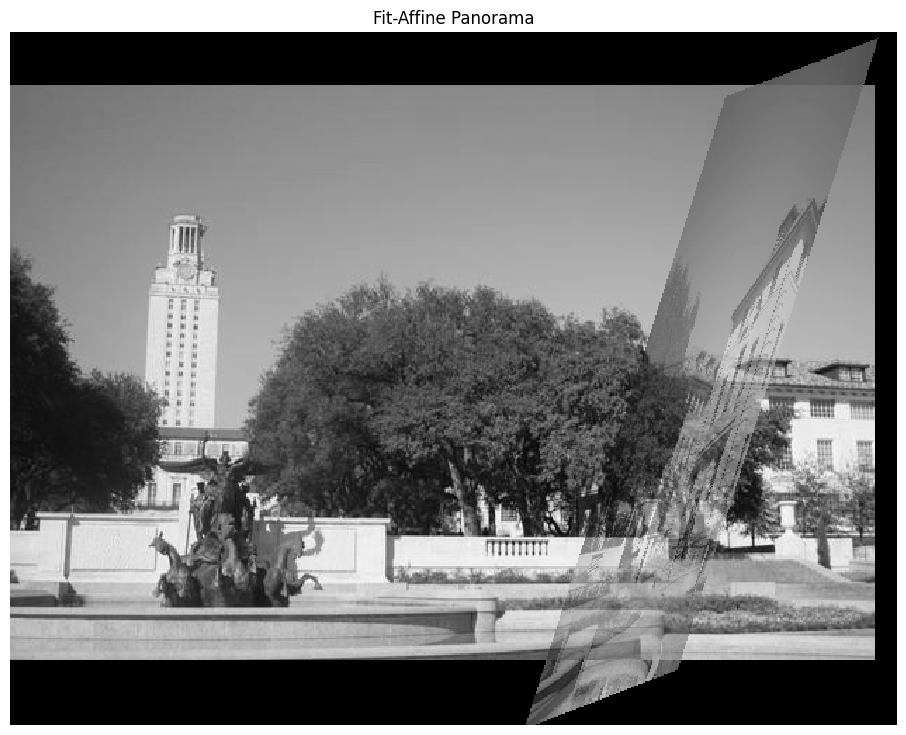

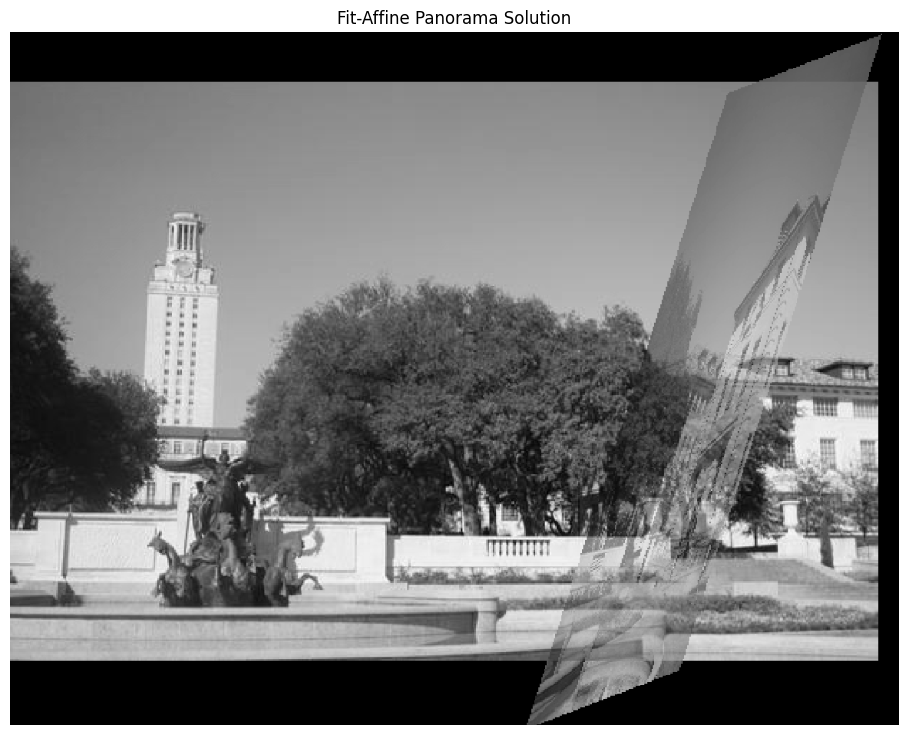

In [14]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

plt.imshow(normalized)
plt.axis('off')
plt.title('Fit-Affine Panorama')
plt.show()

plt.imshow(imread('solution_fit_affine_panorama.png'))
plt.axis('off')
plt.title('Fit-Affine Panorama Solution')
plt.show()

## 3. RANSAC (20 points)
Rather than directly feeding all our keypoint matches into **``fit_affine_matrix``**, we can use **RANSAC** ("RANdom SAmple Consensus") to select only "inliers" to use for computing the transformation matrix.

Use Euclidean distance as a measure of inliers vs. outliers.


The steps of RANSAC are:
1. Select random set of matches
2. Compute affine transformation matrix
      - You can call your **`fit_affine_matrix`** function for this. **Make sure to explicitly pass in `to_pad=False`.**
3. Find inliers using the given threshold
4. Repeat and keep the largest set of inliers (use >, i.e. break ties by whichever set is seen first)
5. Re-compute least-squares estimate on all of the inliers

Implement **`ransac`** below.

In [15]:
def ransac(keypoints1, keypoints2, matches, n_iters=200, threshold=20):
    """
    Use RANSAC to find a robust affine transformation:

        1. Select random set of matches
        2. Compute affine transformation matrix
        3. Compute inliers via Euclidean distance
        4. Keep the largest set of inliers (use >, i.e. break ties by whichever set is seen first)
        5. Re-compute least-squares estimate on all of the inliers

    Update max_inliers as a boolean array where True represents the keypoint
    at this index is an inlier, while False represents that it is not an inlier.

    Hint:
        You can use fit_affine_matrix to compute the affine transformation matrix.
        Make sure to pass in to_pad=False, since we pad the matches for you here.

        You can compute elementwise boolean operations between two numpy arrays,
        and use boolean arrays to select array elements by index:
        https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing

    Args:
        keypoints1: M1 x 2 matrix, each row is a point
        keypoints2: M2 x 2 matrix, each row is a point
        matches: N x 2 matrix, each row represents a match
            [index of keypoint1, index of keypoint 2]
        n_iters: the number of iterations RANSAC will run
        threshold: the threshold to find inliers

    Returns:
        H: a robust estimation of affine transformation from keypoints2 to
        keypoints 1
    """

    # Copy matches array, to avoid overwriting it
    orig_matches = matches.copy()
    matches = matches.copy()

    N = matches.shape[0]
    n_samples = int(N * 0.2)

    matched1 = pad(keypoints1[matches[:,0]])
    matched2 = pad(keypoints2[matches[:,1]])

    max_inliers = np.zeros(N, dtype=bool)
    n_inliers = 0

    # RANSAC iteration start

    # Note: while there're many ways to do random sampling, we use
    # `np.random.shuffle()` followed by slicing out the first `n_samples`
    # matches here in order to align with the autograder.
    # Sample with this code:
    for i in range(n_iters):
        # 1. Select random set of matches
        np.random.shuffle(matches)
        samples = matches[:n_samples]
        sample1 = pad(keypoints1[samples[:,0]])
        sample2 = pad(keypoints2[samples[:,1]])

    ### YOUR CODE HERE
        H_candidate = fit_affine_matrix(sample1, sample2, to_pad=False)
        transformed = matched2 @ H_candidate
        dists = np.linalg.norm(matched1[:, :2] - transformed[:, :2], axis=1)
        inliers = dists < threshold

        if np.sum(inliers) > n_inliers:
            n_inliers = np.sum(inliers)
            max_inliers = inliers

    final_inliers_1 = matched1[max_inliers]
    final_inliers_2 = matched2[max_inliers]

    H = fit_affine_matrix(final_inliers_1, final_inliers_2, to_pad=False)

    ### END YOUR CODE

    return H, orig_matches[max_inliers]

Now, run through the following cells to get a panorama. You'll be able to see the difference from the result we got before without RANSAC.

Robust matches shape =  (14, 2)
H = 
 [[ 1.01796212e+00  2.42214470e-02  0.00000000e+00]
 [-2.92511861e-02  1.03559397e+00  0.00000000e+00]
 [ 2.03684578e+01  2.58675281e+02  1.00000000e+00]]


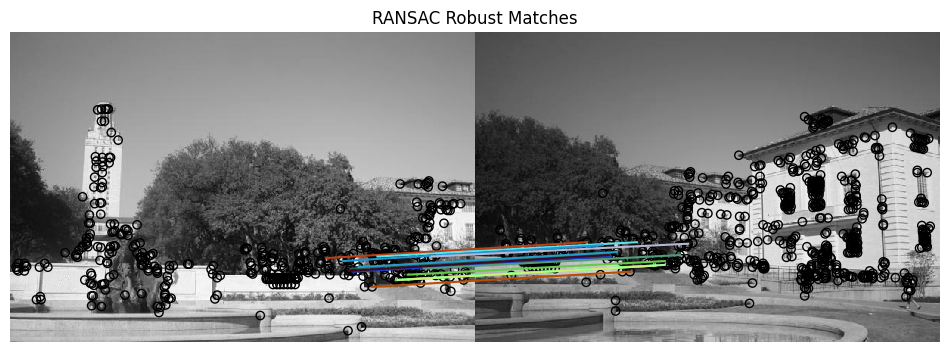

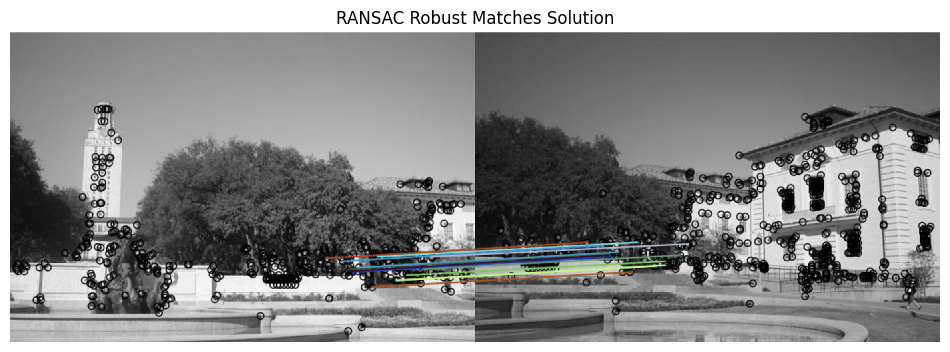

In [12]:
# Set seed to compare output against solution image
np.random.seed(131)

H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.title('RANSAC Robust Matches')
plt.show()

plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Robust Matches Solution')
plt.show()

We can now use the tranformation matrix $H$ computed using the robust matches to warp our images and create a better-looking panorama.

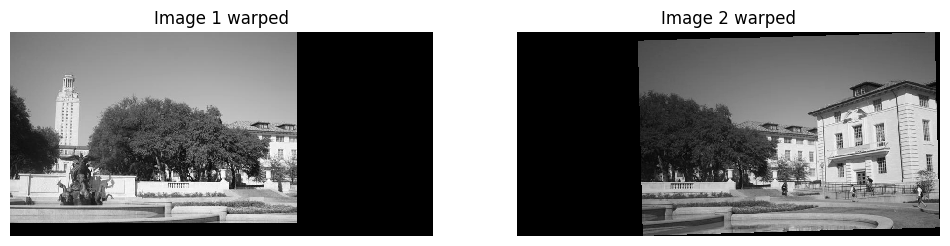

In [13]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

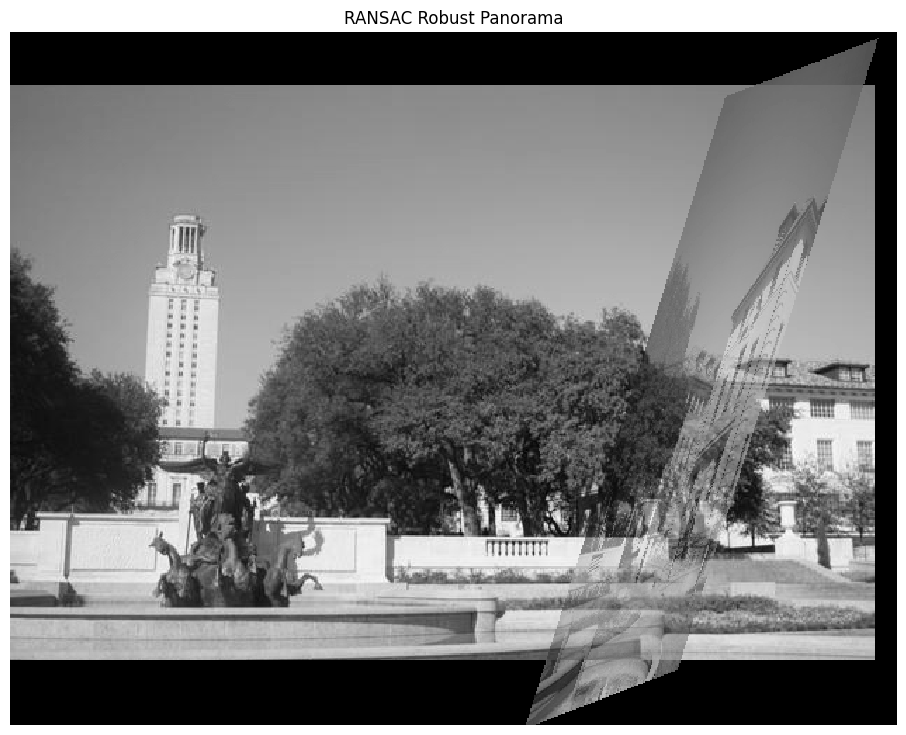

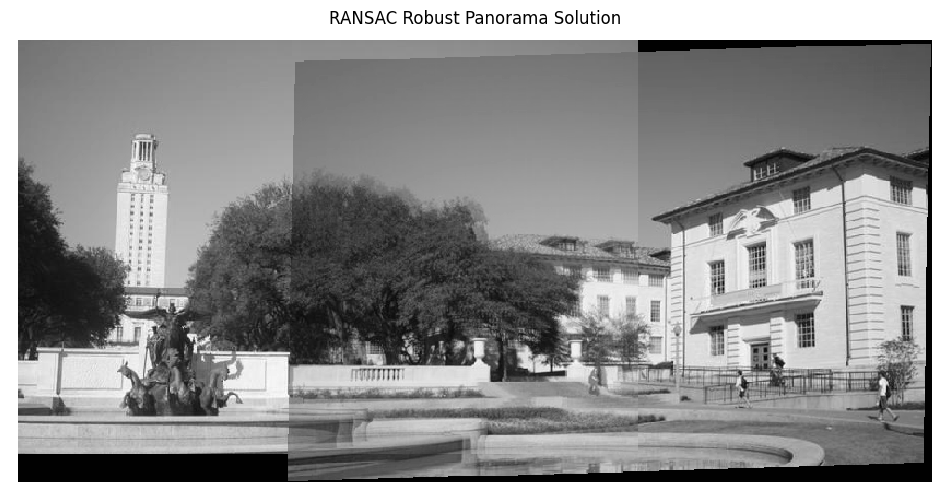

In [17]:
# Merge the two images
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.title('RANSAC Robust Panorama')
plt.show()

plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Robust Panorama Solution')
plt.show()

## 4. Better Image Merging (10 points)
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. Using a very simple technique called linear blending, we can smooth out a lot of these artifacts.

Currently, all the pixels in the overlapping region are weighted equally. However, since the pixels at the left and right ends of the overlap are very well complemented by the pixels in the other image, they can be made to contribute less to the final panorama.

Linear blending can be done with the following steps:

1. Define left and right margins for blending to occur between
2. Define a weight matrix for image 1 such that:
    - From the left of the output space to the left margin the weight is 1
    - From the left margin to the right margin, the weight linearly decrements from 1 to 0
3. Define a weight matrix for image 2 such that:
    - From the right of the output space to the right margin the weight is 1
    - From the left margin to the right margin, the weight linearly increments from 0 to 1
4. Apply the weight matrices to their corresponding images
5. Combine the images

In **`linear_blend`** below, implement the linear blending scheme to make the panorama look more natural.

In [59]:
def linear_blend(img1_warped, img2_warped):
    """
    Linearly blend img1_warped and img2_warped by following the steps:

    1. Define left and right margins (already done for you)
    2. Define a weight matrices for img1_warped and img2_warped
        np.linspace and np.tile functions will be useful
    3. Apply the weight matrices to their corresponding images
    4. Combine the images

    Args:
        img1_warped: Refernce image warped into output space
        img2_warped: Transformed image warped into output space

    Returns:
        merged: Merged image in output space
    """

    out_H, out_W = img1_warped.shape # Height and width of output space
    img1_mask = (img1_warped != 0)  # Mask == 1 inside the image
    img2_mask = (img2_warped != 0)  # Mask == 1 inside the image

    # Find column of middle row where warped image 1 ends
    # This is where to end weight mask for warped image 1
    right_margin = out_W - np.argmax(np.fliplr(img1_mask)[out_H//2, :].reshape(1, out_W), 1)[0]

    # Find column of middle row where warped image 2 starts
    # This is where to start weight mask for warped image 2
    left_margin = np.argmax(img2_mask[out_H//2, :].reshape(1, out_W), 1)[0]

    ### YOUR CODE HERE
    weight1 = np.zeros(out_W)
    weight2 = np.zeros(out_W)
    weight1[:left_margin] = 1
    if right_margin < out_W:
        weight2[right_margin:] = 1
    if right_margin >= left_margin:
        blend_width = right_margin - left_margin
        ramp = np.linspace(1, 0, blend_width)
        weight1[left_margin:right_margin] = ramp
        weight2[left_margin:right_margin] = 1 - ramp
    else:
        overlap_slice = slice(left_margin, right_margin+1)
        weight1[overlap_slice] = 0.5
        weight2[overlap_slice] = 0.5
    weight1_mat = np.tile(weight1, (out_H, 1))
    weight2_mat = np.tile(weight2, (out_H, 1))
    merged = weight1_mat * img1_warped + weight2_mat * img2_warped
    ### END YOUR CODE

    return merged

Now let's see how linear blending improves our result.

EC1 keypoints1 shape =  (396, 2)
EC1 keypoints2 shape =  (627, 2)
EC1 desc1 shape =  (396, 256)
EC1 desc2 shape =  (627, 256)
Robust matches shape =  (43, 2)
H = 
 [[ 1.04208721e+00  6.75533965e-02  0.00000000e+00]
 [-2.84886715e-02  1.04672492e+00  0.00000000e+00]
 [ 1.30064490e+01  2.43335682e+02  1.00000000e+00]]
Output shape: [445 915]
Offset: [-4.51408398  0.        ]


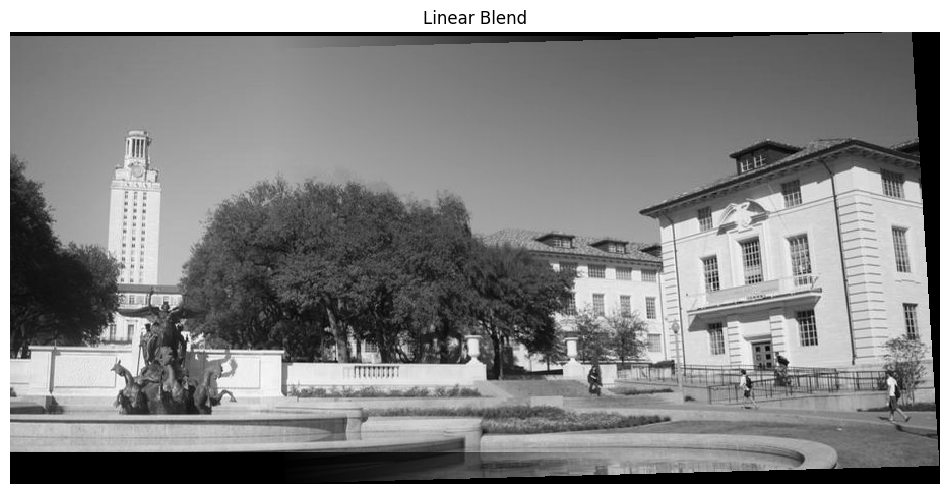

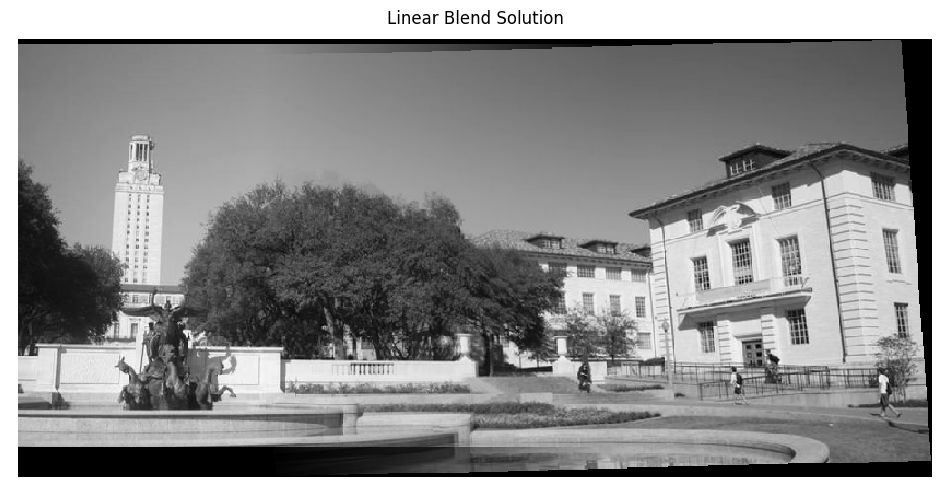

In [60]:
img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

# Set seed to compare output against solution
np.random.seed(131)

# Detect keypoints in both images
ec1_keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)
ec1_keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)

print("EC1 keypoints1 shape = ", ec1_keypoints1.shape)
print("EC1 keypoints2 shape = ", ec1_keypoints2.shape)

# Extract features from the corners
ec1_desc1 = describe_keypoints(img1, ec1_keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=16)
ec1_desc2 = describe_keypoints(img2, ec1_keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=16)

print("EC1 desc1 shape = ", ec1_desc1.shape)
print("EC1 desc2 shape = ", ec1_desc2.shape)

# Match descriptors in image1 to those in image2
ec1_matches = match_descriptors(ec1_desc1, ec1_desc2, 0.7)

H, robust_matches = ransac(ec1_keypoints1, ec1_keypoints2, ec1_matches, threshold=1)
print("Robust matches shape = ", robust_matches.shape)
print("H = \n", H)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)

# Warp images into output space
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Merge the warped images using linear blending scheme
merged = linear_blend(img1_warped, img2_warped)

plt.imshow(merged)
plt.axis('off')
plt.title('Linear Blend')
plt.show()

plt.imshow(imread('solution_linear_blend.png'))
plt.axis('off')
plt.title('Linear Blend Solution')
plt.show()

## 5. Stitching Multiple Images (10 points)
Implement **`stitch_multiple_images`** below to stitch together an ordered chain of images.

Given a sequence of $m$ images ($I_1, I_2,...,I_m$), take every neighboring pair of images and compute the transformation matrix which converts points from the coordinate frame of $I_{i+1}$ to the frame of $I_{i}$.

Then, select a reference image $I_{\text{ref}}$, which is the first or left-most image in the chain. We want our final panorama image to be in the coordinate frame of $I_{\text{ref}}$.

You do **not** need to use linear blending for this problem: it's not included in the solution so the autograder does not expect it.

*Hints:*
- You may want to review the Linear Algebra recitation slides on how to combine the effects of multiple transformation matrices.
- The inverse of transformation matrix has the reverse effect. Use [`numpy.linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) whenever you want to compute matrix inverse.
- Take a look at the code cells in Part 3 (RANSAC) for an example of how to merge warped images and track the overlap using masks.

In [ ]:
def stitch_multiple_images(imgs, desc_func=simple_descriptor, patch_size=5):
    """
    Stitch an ordered chain of images together using custom RANSAC for robust affine estimation.
    
    For images I1, I2, ..., Im we:
      1. Detect keypoints (using a Harris detector and non-maximum suppression).
      2. Compute descriptors (using desc_func on image patches).
      3. Match descriptors between each consecutive pair.
      4. For each pair, use RANSAC to estimate an affine transform H mapping points in I{i+1}
         to I{i}.
      5. Chain the transformations so that each image is mapped into the coordinate frame of I1.
      6. Compute an output canvas large enough for all warped images.
      7. Warp each image and blend them (by averaging in overlapping regions).
    
    Args:
        imgs: List of m images (assumed grayscale).
        desc_func: Function that takes an image patch and returns a 1D descriptor.
        patch_size: Size of the patch around each keypoint.
    
    Returns:
        panorama: The final stitched panorama.
    """
    # 1. Detect keypoints in each image.
    keypoints = []
    for img in imgs:
        # (Assuming you have functions harris_corners and corner_peaks available.)
        kypnts = corner_peaks(harris_corners(img, window_size=3),
                              threshold_rel=0.05,
                              exclude_border=8)
        keypoints.append(kypnts)
    
    # 2. Compute descriptors at each keypoint.
    descriptors = []
    for i, kypnts in enumerate(keypoints):
        desc = describe_keypoints(imgs[i], kypnts,
                                  desc_func=desc_func,
                                  patch_size=patch_size)
        descriptors.append(desc)
    
    # Match keypoints in neighboring images
    matches = []  # matches[i] corresponds to matches between
                  # descriptors[i] and descriptors[i+1]
    for i in range(len(imgs)-1):
        mtchs = match_descriptors(descriptors[i], descriptors[i+1], 0.7)
        matches.append(mtchs)
    
    ### YOUR CODE HERE
    transforms = []
    for i in range(len(imgs) - 1):
        H_matrix, _ = ransac(
            keypoints[i], 
            keypoints[i + 1], 
            matches[i]
        )
        transforms.append(H_matrix)

    accumulated_transforms = [np.eye(3)]
    for H_matrix in transforms:
        new_transform = (
            H_matrix @ accumulated_transforms[-1]
        )
        accumulated_transforms.append(new_transform)

    final_canvas = np.zeros((0, 0))
    max_offset = np.zeros(2)

    for i in range(len(imgs)):
        temp_canvas, temp_offset = get_output_space(
            imgs[i], 
            imgs, 
            accumulated_transforms
        )
        
        if temp_canvas.shape[0] > final_canvas.shape[0]:
            final_canvas = temp_canvas
            max_offset = temp_offset

    aligned_images = []
    for i in range(len(imgs)):
        transformed_img = warp_image(
            imgs[i], 
            accumulated_transforms[i], 
            final_canvas, 
            max_offset
        )
        valid_mask = (transformed_img != -1)
        transformed_img[~valid_mask] = 0
        aligned_images.append(transformed_img)

    stitched_panorama = aligned_images[0]
    for i in range(1, len(aligned_images)):
        stitched_panorama = linear_blend(
            stitched_panorama, 
            aligned_images[i]
        )
    panorama = stitched_panorama
    ### END YOUR CODE
    return panorama


We can now visualize the final panorama!

In [84]:
# Set seed to compare output against solution
np.random.seed(131)

# Load images to be stitched
ec2_img1 = imread('yosemite1.jpg', as_gray=True)
ec2_img2 = imread('yosemite2.jpg', as_gray=True)
ec2_img3 = imread('yosemite3.jpg', as_gray=True)
ec2_img4 = imread('yosemite4.jpg', as_gray=True)

imgs = [ec2_img1, ec2_img2, ec2_img3, ec2_img4]

# Stitch images together
panorama = stitch_multiple_images(imgs, desc_func=simple_descriptor, patch_size=5)

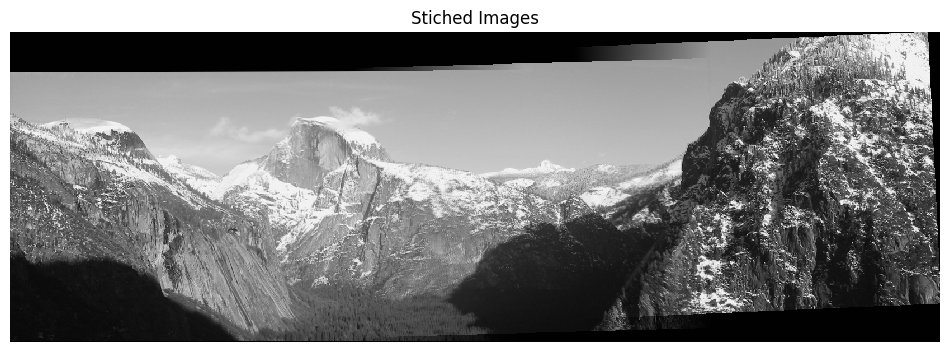

In [85]:
# Visualize final panorama image
plt.imshow(panorama)
plt.axis('off')
plt.title('Stiched Images')
plt.show()

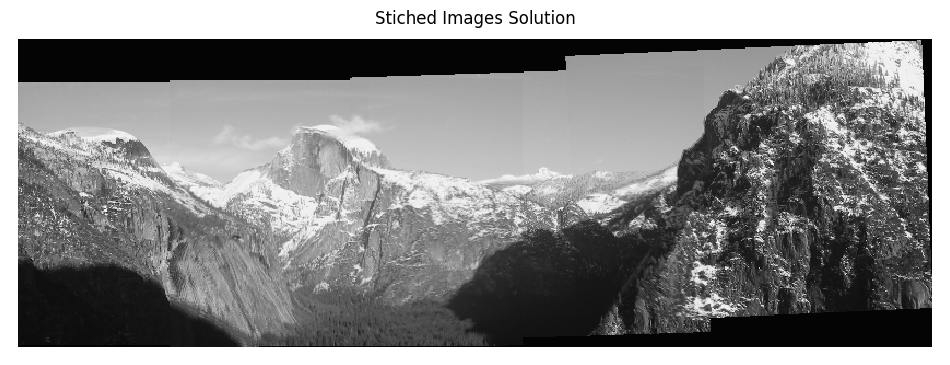

In [67]:
plt.imshow(imread('solution_stitched_images.png'))
plt.axis('off')
plt.title('Stiched Images Solution')
plt.show()

# Part 2: Epipolar Geometry and Stereo Matching

## 1. Drawing Epipolar Lines (10 points)

Recall our discussion of epipolar geometry from Lecture 9.

The **epipolar constraint** states that if we observe a single point $x$ in one image, we must find the corresponding $x'$ in the other image along the **epipolar line** corresponding to $x$. We represented the epipolar constraint as an equation $$x'^T \mathbf{F}x = 0$$ where $\bf F$ is the **fundamental matrix**. We discussed estimating $\bf F$ using the normalized 8-point algorithm.

In this problem, we'll use the OpenCV library to estimate this fundamental matrix and draw epipolar lines on two images that capture the same scene from different cameras. First, run the following cell to load and display the two images we'll be working with.

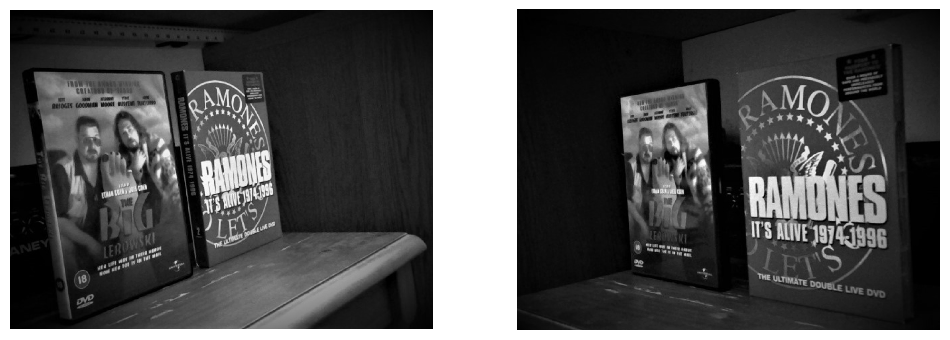

In [42]:
img1 = cv.imread('dvd_left.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('dvd_right.png', cv.IMREAD_GRAYSCALE)

plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

Similar to Homework 2, we'll use SIFT to extract keypoints and descriptors from the two images.

 We'll then use a [FLANN-based nearest neighbor search](https://github.com/flann-lib/flann) to filter good matches.









In [43]:
sift = cv.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

**Now, fill in code in the cell below.**
1. Estimate the fundamental matrix using a call to **[`cv.findFundamentalMat`](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a)** with the relevant parameters.
  - For the `method` parameter, you can play around with different values and compare the results you get.
  - In our solution code, we used `cv.FM_LMEDS`, which applies the LMedS (Least Median of Squares) algorithm.

2. Using the `mask` output as a boolean mask, select only the inlier points (those where `mask.ravel()` is 1) in both images.

3. Compute the epipolar lines for both images using [**`cv.computeCorrespondEpilines`**](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7).
  - You'll need to reshape the points array you pass in from to be shape `(N, 1, 2)`.

In [44]:
# Estimate the fundamental matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)

# Select only the inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Compute the epipolar lines in image 1 corresponding to points in image 2
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)

# Compute the epipolar lines in image 2 corresponding to points in image 1
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)

Finally, we can visualize the epipolar lines on both the left and right images.

*Note: It's normal to get different outputs here each time you re-run the above cells. <br>
If your output isn't similar to the solution, try re-running this part of the notebook.*

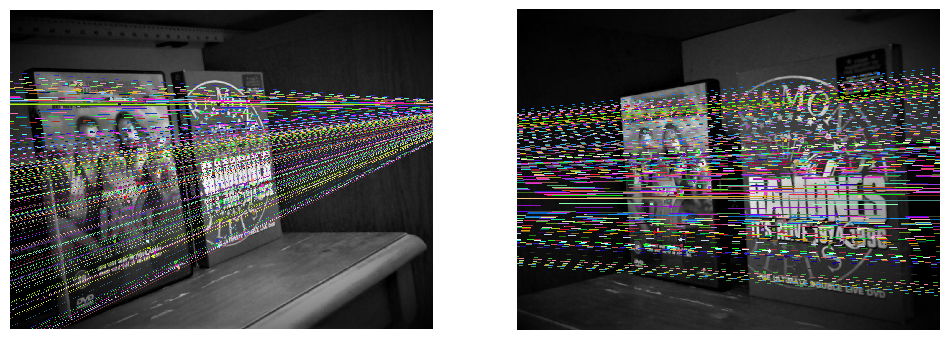

In [45]:
# Helper function to draw the epipolar lines
def drawlines(img1, img2, lines, pts1, pts2):
  r, c = img1.shape
  img1 = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
  img2 = cv.cvtColor(img2, cv.COLOR_GRAY2BGR)

  for r, pt1, pt2 in zip(lines, pts1, pts2):
      color = tuple(np.random.randint(0,255,3).tolist())
      x0, y0 = map(int, [0, -r[2]/r[1] ])
      x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
      img1 = cv.line(img1, (x0,y0), (x1,y1), color, 1)
      img1 = cv.circle(img1, tuple(pt1), 5, color, -1)
      img2 = cv.circle(img2, tuple(pt2), 5, color, -1)
  return img1, img2

# Draw epipolar lines corresponding to points in right image on left image
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Draw epipolar lines corresponding to points in left image on right image
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121)
plt.imshow(img5)
plt.axis('off')
plt.subplot(122)
plt.imshow(img3)
plt.axis('off')
plt.show()

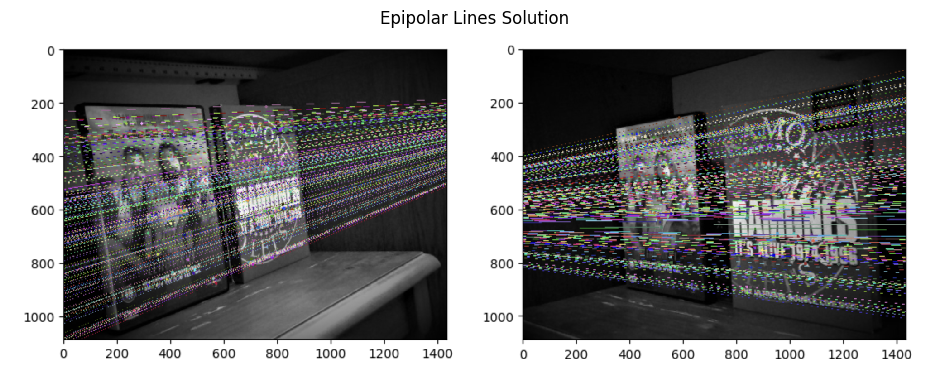

In [47]:
plt.imshow(imread('solution_epipolar_lines.png'))
plt.axis('off')
plt.title('Epipolar Lines Solution')
plt.show()

## 2. Computing Disparity Map (5 points)

Recall the basic stereo matching algorithm we discussed in Lecture 9: for each pixel $x$ in the first image, we can find the corresponding epipolar scanline in the second image, pick the best matching pixel $x'$ on that scaline, and then compute the $\textbf{disparity} = x - x'$.

In this section, we'll work with these two images of a motorcycle.

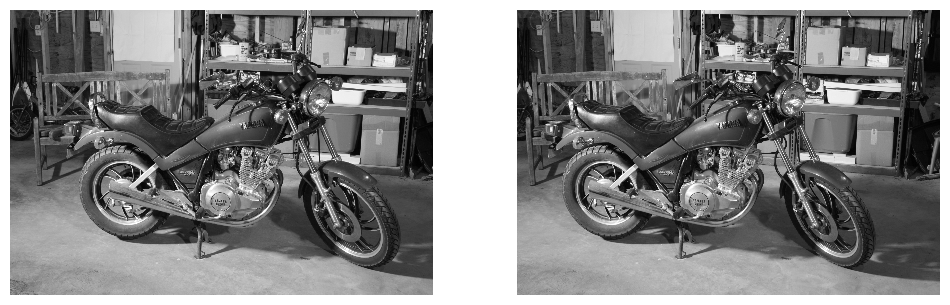

In [48]:
img1 = cv.imread('motorcycle_left.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('motorcycle_right.png', cv.IMREAD_GRAYSCALE)

plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

Given these two images, we can compute a disparity map using OpenCV's stereo semi-global block matching **[`StereoSGBM`](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html#details).**

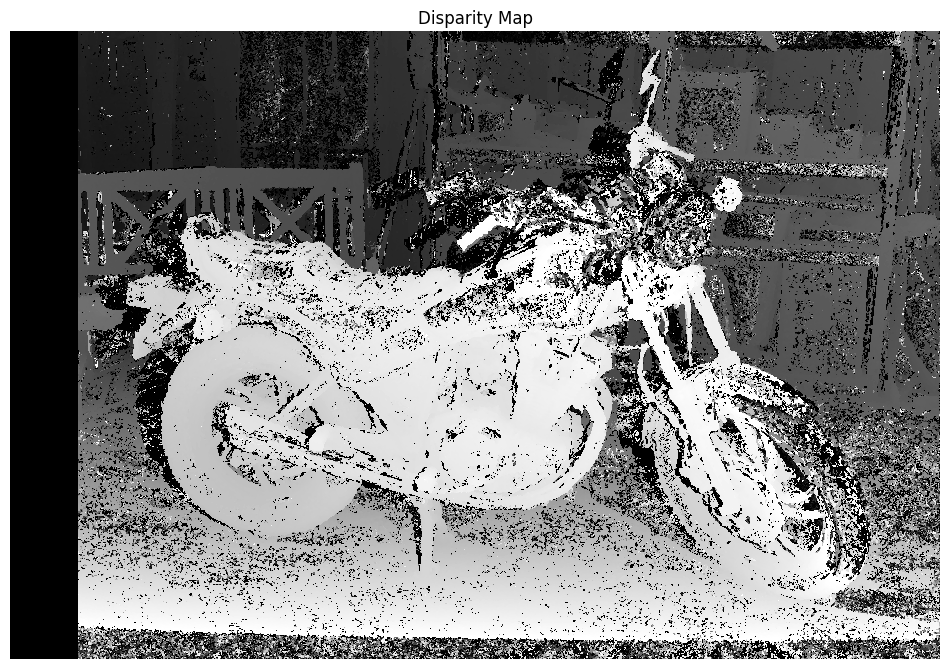

In [49]:
stereo = cv.StereoSGBM_create(minDisparity=16, numDisparities=200, blockSize=7)
disparity = stereo.compute(img1, img2).astype(np.float32) / 16.0

plt.imshow(disparity)
plt.axis('off')
plt.title('Disparity Map')
plt.show()

**Question:** Does the disparity map above look reasonable to you? Why do closer objects appear lighter and farther objects appear darker? What additional steps would we need to take to be able to convert this disparity map to a dense depth map?

**Your Answer Here:** 

The disparity map looks reasonable. Disparity is the pixel shift between stereo images and it is inversely proportional to depth. Closer objects appear lighter because they have higher disparity values, while farther objects appear darker due to lower disparity values. To convert this disparity map to a dense depth map, we need to know the camera parameters and apply the depth formula where depth is calculated as the product of focal length and baseline divided by disparity. 



## 3. Rerendering from Different Camera Viewpoint (Extra Credit)

We can use the disparity map computed above to rerender the motorcycle image from a new camera viewpoint.

To do this, we have some basic function templates below.

1. In **`disparity_to_depth`**, convert from disparity to depth, using the relation $$\text{depth} = \frac{B * f}{\text{disparity}}$$ Estimates of $B$ (the baseline) and $f$ (the focal length) are given to you.

2. In **`backproject_to_3D`**, backproject the 2D image points to 3D using the full camera intrinsics $K$.

3. In **`transform_3D_points`**, apply the given rotation and translation matrices to the 3D points.

4. In **`project_to_new_image`**, reproject the translated 3D points onto our new image plane (our new viewpoint).

You can add any other functions that you want to improve the appearance of the rerendered image!

In [52]:
### EXTRA CREDIT FUNCTIONS (feel free to add any functions to this)

def disparity_to_depth(disparity, B, f):
    """
    Convert disparity map to depth map.

    Args:
        disparity: disparity output from OpenCV's stereo matching algorithm
        B: baseline
        f: focal length

    Returns:
        depth: depth map

    Hint:
        When applying the formula (B * f) / disparity, add a small
        value (like 1e-6) to the denominator to avoid division by zero.
    """

    ### YOUR CODE HERE
    depth = (B * f) / (disparity + 1e-6)
    ### END YOUR CODE

    return depth

def backproject_to_3D(disparity, K, B):
    """
    Convert disparity map to 3D points using camera intrinsics.

    Args:
        disparity: disparity output from OpenCV's stereo matching algorithm
        K: full camera intrinsics matrix
        B: baseline

    Returns:
        points_3D: 3D points in the original camera frame
    """

    ### YOUR CODE HERE
    h, w = disparity.shape
    i, j = np.indices((h, w))
    Z = (B * K[0, 0]) / (disparity + 1e-6)
    X = (i - K[0, 2]) * Z / K[0, 0]
    Y = (j - K[1, 2]) * Z / K[1, 1]
    points_3D = np.stack((X, Y, Z), axis=-1)

    ### END YOUR CODE

    return points_3D

def transform_3D_points(points_3D, R_new, T_new):
    """
    Apply rigid transformation to 3D points.

    Args:
        points_3D: 3D points in the original camera frame
        R_new: 3x3 rotation matrix
        T_new: 3x1 translation vector

    Returns:
        points_3D_transformed: 3D points in the new camera frame
    """

    ### YOUR CODE HERE
    points_3D_homogeneous = np.concatenate(
        (points_3D, np.ones(points_3D.shape[:2] + (1,))), axis=2
    )
    transformation_matrix = np.hstack((R_new, T_new.reshape(-1, 1)))
    points_3D_transformed_homogeneous = points_3D_homogeneous @ transformation_matrix.T
    points_3D_transformed = points_3D_transformed_homogeneous

    ### END YOUR CODE

    return points_3D_transformed

def project_to_new_image(points_3D_transformed, K_new, image):
    """
    Project transformed 3D points back to the 2D image plane.

    Args:
        points_3D_transformed: 3D points in the new camera frame
        K_new: full camera intrinsics matrix for the new camera
        image: original image

    Returns:
        output_image: original image in the new camera frame
    """

    ### YOUR CODE HERE
    h, w, _ = points_3D_transformed.shape
    points_3D_transformed_flat = points_3D_transformed.reshape(-1, 3)
    points_2D_homogeneous = points_3D_transformed_flat @ K_new.T
    points_2D = points_2D_homogeneous[:, :2] / points_2D_homogeneous[:, 2:]

    output_image = np.zeros_like(image)
    for idx, (x, y) in enumerate(points_2D):
        x, y = int(x), int(y)
        if 0 <= x < w and 0 <= y < h:
            output_image[y, x] = image[idx // w, idx % w]

    ### END YOUR CODE
    
    return output_image

The following cell will test out the functions above (feel free to modify it depending on your specific implementation).

In [53]:
image = cv.imread('motorcycle_left.png')
image_height, image_width, _ = image.shape

def estimate_intrinsics(image_width, image_height, fov=960):
    """Estimate camera intrinsics with an assumed field of view in degrees."""
    f = image_width / (2 * np.tan(np.radians(fov / 2)))
    K = np.array([[f, 0, image_width / 2],
                  [0, f, image_height / 2],
                  [0, 0, 1]])
    return f, K

f, K = estimate_intrinsics(image_width, image_height)
B = 0.1 # an estimate
K_new = K

# New camera pose (you can set these to whatever you like)
R_new = np.eye(3)  # No rotation
T_new = np.array([0.02, 0, 0])  # Move 2cm right

# Compute 3D points and transform to new view
points_3D = backproject_to_3D(disparity, K, B)
points_3D_transformed = transform_3D_points(points_3D, R_new, T_new)
output_image = project_to_new_image(points_3D_transformed, K_new, image)

cv.imwrite('motorcycle_novel_view.png', output_image)

True

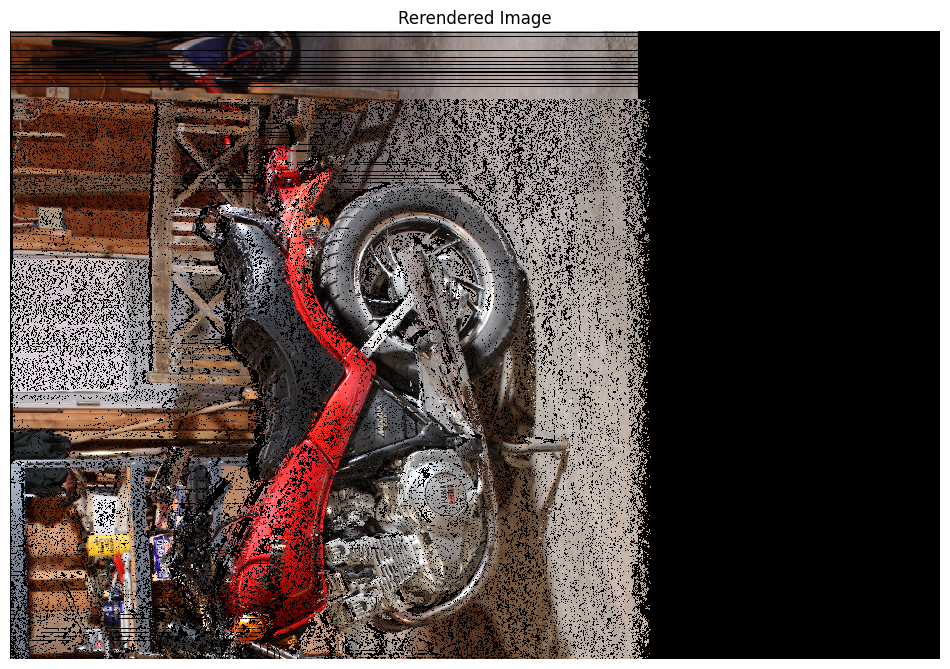

In [54]:
plt.imshow(imread('motorcycle_novel_view.png'))
plt.axis('off')
plt.title('Rerendered Image')
plt.show()